# Routines to Test LC Utils

(1) Non-standard libraries required:
- pyfits

(2) Some files that need a "2to3 -w" conversion:
- lctools/hd5flc/hdf5lc.py
- tsig/lightcurve/lightcurve.py

(3) Select data folder containing .h5 light curves

In [4]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.robust import scale
import collections
import h5py

# From Chelsea
sys.path.append('../Modules')

# From astronet
sys.path.append('../Modules') 
from astronet import median_filter


In [5]:
lcfolder  = "../Data/2020_03_26_TestData/LC/"
blsfolder = "../Data/2020_03_26_TestData/BLS/"
outputfolder = "./"

# Find all light curve files

# Loop through all files in LC folder
allfiles = os.listdir(lcfolder)
lcfiles  = []
blsfiles = []
nomit    = 0
for lcfile in allfiles:
    
    # construct .blsanal filepath given .h5 filepath
    blsfile = os.path.join(blsfolder,lcfile).replace("h5","blsanal")

    # check LC file has .h5 extension
    # check accompanying BLS file exists
    if (lcfile.split(".")[-1] == "h5" and os.path.exists(blsfile)):
        lcfiles.append(lcfile)
        blsfiles.append(blsfile)
    else:
        nomit += 1
        
nfiles = len(lcfiles)
print("Found {} lightcurves and ommitted {} files".format(nfiles,nomit))

Found 96 lightcurves and ommitted 0 files


- 3 lightcurves, phase folded period = 1, binned, all apertures
- 1 lightcurve, phase folded period = 2, halfperiod = 2, binned, main aperture only

In [14]:
# Each single period phase folded lightcurve has 201 bins
nbins = 201

# Double period phase folded light curve
nbins_double = 201

# Number of apertures
naps  = 3 

# Array that holds all single period lcs
errors   = []

# Loop over each lightcurve
for i in range(nfiles):
    print("{} / {}\r".format(i,nfiles-1),end="")
    try:
        # Read in LC from existing .h5
        filepath = os.path.join(lcfolder,lcfiles[i])
        h5file = h5py.File(os.path.join(lcfolder,lcfiles[i]),'r')
        og_time = np.array(h5file["LightCurve"]["BJD"])
        
        # Read in period
        blsanal = np.genfromtxt(blsfiles[i], dtype=float, delimiter=' ', names=True) 
        period  = blsanal['BLS_Period_1_0']

        # Create .h5 to store binned data
        if os.path.exists(os.path.join(outputfolder,lcfiles[i])):
              os.remove(os.path.join(outputfolder,lcfiles[i]))
        globalviews = h5py.File(os.path.join(outputfolder,lcfiles[i]),"w")

        # Check which is best ap
        best_ap = "Aperture_%.3d" % h5file["LightCurve"]["AperturePhotometry"].attrs['bestap']
        globalviews.create_dataset("bestap",(1,), data =  int(best_ap[-3:]))

        # Loop over all apertures creating single period binned lightcurves
        aps_list = list(h5file["LightCurve"]["AperturePhotometry"].keys())
        for j in range(len(aps_list)):

            all_mag  = np.array(h5file["LightCurve"]["AperturePhotometry"]["Aperture_%.3d" % j]["KSPMagnitude"])

            real_indices = ~np.isnan(all_mag)
            all_mag  = all_mag[real_indices]
            all_time = og_time[real_indices]

            mad           = scale.mad(all_mag)
            valid_indices = np.where(all_mag > np.median(all_mag)-5*mad)
            assert len(valid_indices) <= 1, "Need more data points"

            all_mag       = all_mag[valid_indices]
            all_time      = all_time[valid_indices]

            # Convert mag to flux
            all_flux = 10.**(-(all_mag - np.median(all_mag))/2.5)

            # Phase Fold
            half_period  = period / 2
            folded_time  = np.mod(all_time + (half_period), period) - half_period
            sorted_i     = np.argsort(folded_time)
            folded_time  = folded_time[sorted_i]
            folded_flux  = all_flux[sorted_i]

            # Bin with median values
            bin_width = period * 1.2 / nbins
            (tmin,tmax) = (-period / 2, period / 2)
            view  = median_filter.median_filter(folded_time, folded_flux, nbins, bin_width, tmin,tmax)

            # Normalize
            view -= np.median(view)
            view /= np.abs(np.min(view))  # breaks if min(view) is zero...

            # Place minimum flux at center most index
            view = collections.deque(view)
            minindex     = np.argmin(view)
            view.rotate(100 - minindex)
            globalviews.create_dataset(aps_list[j],(nbins,),dtype=float, data = np.array(view))

        # Repeat with double period light curve
        all_mag  = np.array(h5file["LightCurve"]["AperturePhotometry"][best_ap]["KSPMagnitude"])

        real_indices = ~np.isnan(all_mag)
        all_mag  = all_mag[real_indices]
        all_time = og_time[real_indices]

        mad           = scale.mad(all_mag)
        valid_indices = np.where(all_mag > np.median(all_mag)-5*mad)

        all_mag       = all_mag[valid_indices]
        all_time      = all_time[valid_indices]


        # Convert mag to flux
        all_flux = 10.**(-(all_mag - np.median(all_mag))/2.5)

        # Phase Fold
        period *= 2
        half_period  = period / 4
        folded_time  = np.mod(all_time + (half_period), period) - half_period
        sorted_i     = np.argsort(folded_time)
        folded_time  = folded_time[sorted_i]
        folded_flux  = all_flux[sorted_i]

        # Bin with median values
        bin_width = period * 1.2 / nbins
        (tmin,tmax) = (-period / 2, period / 2)
        view  = median_filter.median_filter(folded_time, folded_flux, nbins, bin_width, tmin,tmax)

        # Normalize
        view -= np.median(view)
        view /= np.abs(np.min(view))  # breaks if min(view) is zero...
        globalviews.create_dataset("Double",(nbins_double,),dtype=float, data = np.array(view))

        globalviews.close()
    except:
        print("Could not read in {}".format(filepath))
        errors.append(lcfiles[i])
        globalviews.close()
        os.remove(os.path.join(outputfolder,lcfiles[i]))
print("{} errors".format(len(errors)))

0 errors


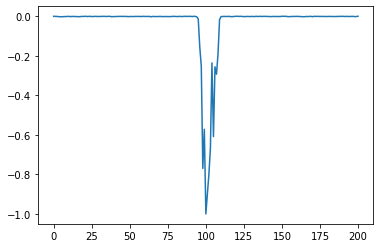

In [26]:
test = h5py.File(os.path.join(outputfolder,lcfiles[70]),'r')
d = np.array(test["Aperture_%.3d" % test["bestap"][0]])
plt.plot(d)
            